In [17]:
# 1) Présentation du dataset

# Analyse des ventes e-commerce — Online Retail

## Contexte
# Ce projet vise à analyser les transactions d’un site e-commerce afin de mieux comprendre
# les performances commerciales, le comportement des clients et les tendances de vente.

## Source des données
# Dataset "Online Retail" – UCI Machine Learning Repository  
# Période : 2010–2011  
# Nombre de lignes : ~500 000 transactions

## Objectifs
# - Analyser le chiffre d’affaires
# - Identifier les produits et pays clés
# - Étudier le comportement client
# - Produire des visualisations exploitables

In [19]:
# 2) Importer des librairies

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# 3) Chargement des données

df = pd.read_excel("../data/raw/Online Retail.xlsx")

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [6]:
# 4) Exploration des données (EDA)

df.shape
df.info()
df.describe()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [7]:
# 5) Nettoyage des données

# a) Suppression des lignes invalides

df = df.dropna(subset=["CustomerID"])
df = df[df["Quantity"] > 0]
df = df[df["UnitPrice"] > 0]

In [8]:
# b) Conversion des types

df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["CustomerID"] = df["CustomerID"].astype(int)

In [9]:
# c) Création du chiffre d’affaires

df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]

In [10]:
# 6) Analyse des ventes

# a) Chiffre d’affaires total

df["TotalPrice"].sum()

np.float64(8911407.904)

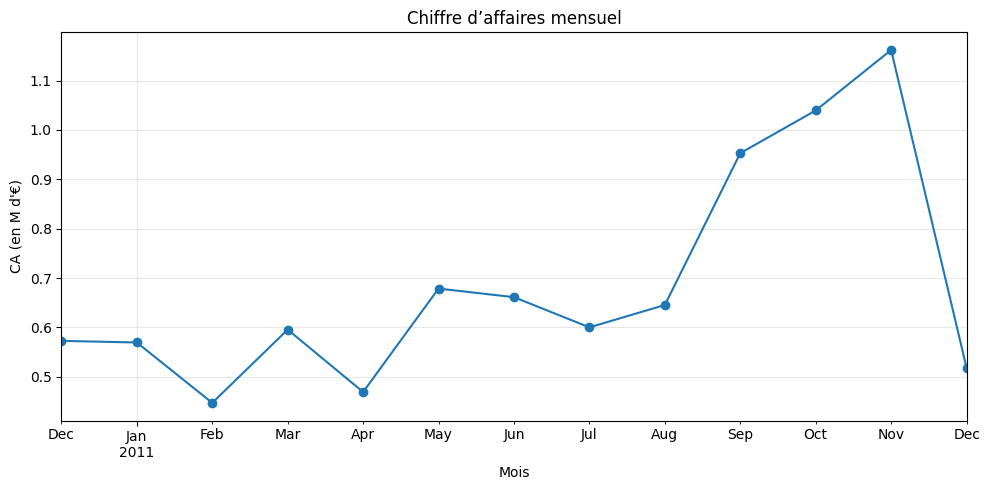

In [29]:
# b) CA par mois

# Création de la colonne mois
df["Month"] = df["InvoiceDate"].dt.to_period("M")

# Calcul du chiffre d'affaires mensuel
monthly_sales = df.groupby("Month")["TotalPrice"].sum()

# Conversion en millions d'euros pour une meilleure lisibilité
monthly_sales_m = monthly_sales / 1000000

# Visualisation
monthly_sales_m.plot(kind="line", figsize=(10, 5), marker="o")
plt.title("Chiffre d’affaires mensuel")
plt.ylabel("CA (en M d'€)")
plt.xlabel("Mois")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


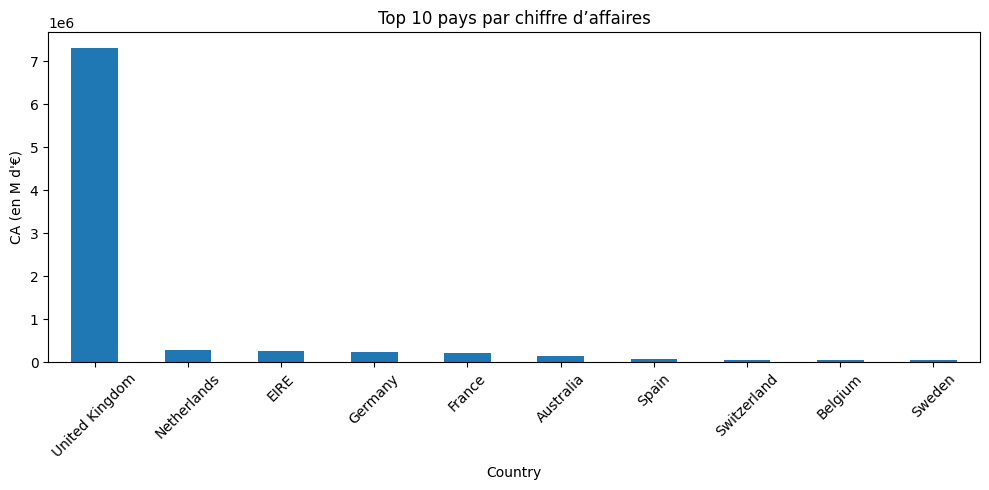

In [30]:
# 7) Analyse par pays

country_sales = (
    df.groupby("Country")["TotalPrice"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

country_sales.plot(kind="bar", figsize=(10,5))
plt.title("Top 10 pays par chiffre d’affaires")
plt.ylabel("CA (en M d'€)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

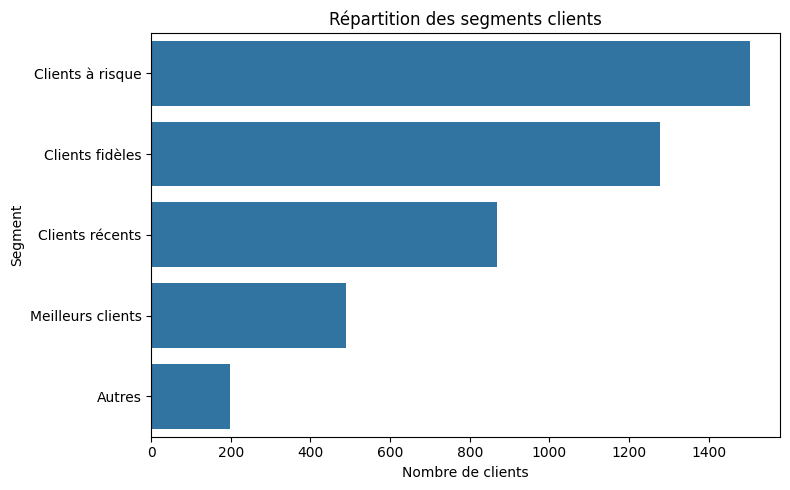

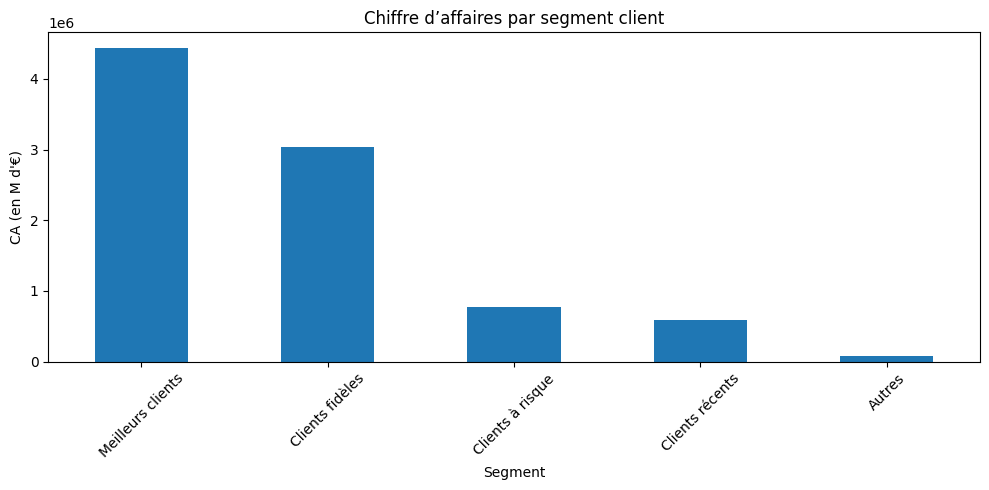

'\nInsights RFM :\n- Une minorité de clients génère une part importante du chiffre d’affaires\n- Les meilleurs clients doivent être fidélisés via des offres exclusives\n- Les clients à risque peuvent être ciblés par des campagnes de réactivation\n- La segmentation RFM permet d’optimiser les stratégies marketing\n'

In [ ]:
# 8) Analyse client — RFM

# Recency : date du dernier achat
# Frequency : nombre de commandes
# Monetary : montant total dépensé


# 1. Préparation des données
# a) Date de référence

# On prend la date la plus récente du dataset comme référence.

reference_date = df["InvoiceDate"].max()
reference_date


# 2. Calcul des métriques RFM
rfm = (
    df.groupby("CustomerID")
    .agg({
        "InvoiceDate": lambda x: (reference_date - x.max()).days, # Quand est-ce que ce client a effectué son dernier achat ?
        "InvoiceNo": "nunique", # Combien de commandes a effectué ce client ?
        "TotalPrice": "sum" # Combien a dépensé ce client ?
    })
)

rfm.columns = ["Recency", "Frequency", "Monetary"]
rfm.head()


# 3. Distribution des métriques RFM
rfm.describe()

# Recency faible = client récent (positif)
# Frequency élevée = client fidèle
# Monetary élevé = client à forte valeur


# 4. Attribution des scores RFM (1 à 4)

# On utilise des quartiles, méthode standard en entreprise.

rfm["R_Score"] = pd.qcut(rfm["Recency"], 4, labels=[4, 3, 2, 1])
rfm["F_Score"] = pd.qcut(
    rfm["Frequency"].rank(method="first"),
    4,
    labels=[1, 2, 3, 4]
)
rfm["M_Score"] = pd.qcut(rfm["Monetary"], 4, labels=[1, 2, 3, 4])

# Conversion des scores en entiers (important pour les comparaisons)
rfm["R_Score"] = rfm["R_Score"].astype(int)
rfm["F_Score"] = rfm["F_Score"].astype(int)
rfm["M_Score"] = rfm["M_Score"].astype(int)

# Score RFM global
rfm["RFM_Score"] = (
    rfm["R_Score"].astype(str)
    + rfm["F_Score"].astype(str)
    + rfm["M_Score"].astype(str)
)

rfm.head()


# 5. Segmentation des clients
def rfm_segment(row):
    if row["R_Score"] == 4 and row["F_Score"] == 4 and row["M_Score"] == 4:
        return "Meilleurs clients"
    elif row["F_Score"] >= 3 and row["M_Score"] >= 3:
        return "Clients fidèles"
    elif row["R_Score"] >= 3:
        return "Clients récents"
    elif row["R_Score"] <= 2 and row["F_Score"] <= 2:
        return "Clients à risque"
    else:
        return "Autres"

rfm["Segment"] = rfm.apply(rfm_segment, axis=1)
rfm["Segment"].value_counts()


# 6. Visualisation des segments clients
plt.figure(figsize=(8, 5))
sns.countplot(
    y=rfm["Segment"],
    order=rfm["Segment"].value_counts().index
)
plt.title("Répartition des segments clients")
plt.xlabel("Nombre de clients")
plt.ylabel("Segment")
plt.tight_layout()
plt.show()


# 7. Valeur par segment
segment_value = (
    rfm.groupby("Segment")["Monetary"]
    .sum()
    .sort_values(ascending=False)
)

segment_value.plot(kind="bar", figsize=(10, 5))
plt.title("Chiffre d’affaires par segment client")
plt.ylabel("CA (en M d'€)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# 8. Insights métier
"""
Insights RFM :
- Une minorité de clients génère une part importante du chiffre d’affaires
- Les meilleurs clients doivent être fidélisés via des offres exclusives
- Les clients à risque peuvent être ciblés par des campagnes de réactivation
- La segmentation RFM permet d’optimiser les stratégies marketing
"""


In [ ]:
# 9) Insights & Conclusion


# - Le chiffre d’affaires montre une forte saisonnalité
# - Une part importante du CA est concentrée sur peu de pays
# - Certains clients génèrent une valeur très élevée
# - Le dataset contient des retours produits à analyser séparément

## Conclusion
# Cette analyse permet d’identifier les leviers d’amélioration commerciale,
# d’optimiser la segmentation client et de guider les décisions business.

In [32]:
# Exporter le dataset nettoyé
import os

# Créer un dossier pour les données finales si nécessaire
os.makedirs("../data/cleaned", exist_ok=True)

# Export CSV
df.to_csv("../data/cleaned/online_retail_cleaned.csv", index=False)

# Export Excel
df.to_excel("../data/cleaned/online_retail_cleaned.xlsx", index=False)

# Export RFM
rfm.to_csv("../data/cleaned/rfm_customers.csv")


In [33]:
# Sauvegarde de tous les graphiques dans le dossier visuals
import os

# Créer le dossier visuals s'il n'existe pas
os.makedirs("../data/visuals/", exist_ok=True)

# 1. Répartition des segments clients
plt.figure(figsize=(8,5))
sns.countplot(
    y=rfm["Segment"],
    order=rfm["Segment"].value_counts().index
)
plt.title("Répartition des segments clients")
plt.xlabel("Nombre de clients")
plt.ylabel("Segment")
plt.tight_layout()
plt.savefig("../data/visuals/segments_clients.png")
plt.close()

# 2. Chiffre d'affaires par segment
plt.figure(figsize=(10,5))
segment_value.plot(kind="bar")
plt.title("Chiffre d’affaires par segment client")
plt.ylabel("CA (en M d'€)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../data/visuals/ca_par_segment.png")
plt.close()

# 3. Chiffre d'affaires mensuel
plt.figure(figsize=(10,5))
monthly_sales_m.plot(kind="line", marker="o")
plt.title("Chiffre d’affaires mensuel")
plt.ylabel("CA (en M d'€)")
plt.xlabel("Mois")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("../data/visuals/ca_mensuel.png")
plt.close()

print("✅ Tous les graphiques ont été sauvegardés dans le dossier 'visuals'.")


✅ Tous les graphiques ont été sauvegardés dans le dossier 'visuals'.
